# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'e:\cifar-10-batches-py' # e:\cifar-10-batches-py || /Users/sean/Data/cifar-10-batches-py
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000L, 3073L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3073L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 3073L)
Test labels shape:  (1000L,)
dev data shape:  (500L, 3073L)
dev labels shape:  (500L,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [14]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.353524
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Cross-entropy loss function measures the negative logarithm of the probability that test points are correctly classified to their true labels (the higher this values is, lower loss will be). Since numbers of images belonging to each class in our dataset are uniformly distributed, this probability, in our case, is some number around 50 (take into account inquality after using np.random.choice) divided by 500 (number of images in __dev__ subset), which is close to 0.1. Therefore, we expect our loss to be close to -log(0.1).

In [15]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.534867 analytic: -1.534867, relative error: 1.475154e-08
numerical: 1.442290 analytic: 1.442290, relative error: 1.139211e-08
numerical: -2.870460 analytic: -2.870460, relative error: 2.198346e-08
numerical: 4.459381 analytic: 4.459381, relative error: 8.727870e-09
numerical: 0.518809 analytic: 0.518809, relative error: 3.700972e-08
numerical: 4.199092 analytic: 4.199092, relative error: 2.098121e-08
numerical: -1.374149 analytic: -1.374149, relative error: 8.339265e-09
numerical: -1.281324 analytic: -1.281324, relative error: 4.500352e-08
numerical: 1.548005 analytic: 1.548004, relative error: 3.389089e-08
numerical: 0.794528 analytic: 0.794528, relative error: 9.877654e-09
numerical: 0.098950 analytic: 0.105136, relative error: 3.031158e-02
numerical: 0.855737 analytic: 0.860622, relative error: 2.846055e-03
numerical: -1.501770 analytic: -1.500662, relative error: 3.690380e-04
numerical: -0.830554 analytic: -0.844446, relative error: 8.294064e-03
numerical: 0.052414 an

In [23]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.353524e+00 computed in 0.087000s
vectorized loss: 2.353524e+00 computed in 0.004000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax

results = {}
best_val = -1
best_softmax = None

learning_rates = [1e-7, 2e-7, 3e-7, 5e-5, 8e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        softmax = Softmax()
        tic = time.time()
        loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, 
                              reg=regularization_strength, num_iters=400, verbose=False)
        toc = time.time()        
        print 'training took %fs' % (toc - tic)
        
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        
        y_train_accuracy = np.mean(y_train_pred == y_train)
        y_val_accuracy = np.mean(y_val_pred == y_val)
        
        results[(learning_rate, regularization_strength)] = (y_train_accuracy, y_val_accuracy)
        if y_val_accuracy > best_val:
            best_val = y_val_accuracy
            best_softmax = softmax


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

training took 4.444000s
training took 2.449000s
training took 2.362000s
training took 2.392000s
training took 2.371000s
training took 2.359000s
training took 2.366000s
training took 2.351000s
training took 2.371000s
training took 2.390000s
training took 2.366000s
training took 2.364000s
training took 2.364000s
training took 2.376000s
training took 2.373000s
training took 2.366000s
training took 2.377000s
training took 2.358000s
training took 2.375000s
training took 2.355000s
training took 2.429000s
training took 2.464000s
training took 2.315000s
training took 2.357000s
training took 2.464000s
training took 2.494000s
training took 2.347000s
training took 2.318000s
training took 2.291000s
training took 2.316000s
training took 2.379000s
training took 2.349000s
training took 2.399000s

cs231n\classifiers\softmax.py:92: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(- np.log(np.exp(scores[range(num_train), y[range(num_train)]]) / row_sum_exps))
cs231n\classifiers\softmax.py:106: RuntimeWarning: overflow encountered in double_scalars
  f_i = scores[i, :]



training took 2.356000s
training took 2.401000s
training took 2.336000s
training took 2.300000s
training took 2.315000s
training took 2.310000s
training took 2.331000s
training took 2.298000s
training took 2.304000s
training took 2.321000s
training took 2.305000s
training took 2.303000s
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.206551 val accuracy: 0.200000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.224265 val accuracy: 0.240000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.248000 val accuracy: 0.255000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.264755 val accuracy: 0.271000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.291286 val accuracy: 0.307000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.296857 val accuracy: 0.311000
lr 1.000000e-07 reg 7.000000e+04 train accuracy: 0.305857 val accuracy: 0.325000
lr 1.000000e-07 reg 8.000000e+04 train accuracy: 0.302653 val accuracy: 0.316000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.310735 val a

cs231n\classifiers\softmax.py:106: RuntimeWarning: overflow encountered in multiply
  f_i = scores[i, :]


In [26]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.378000


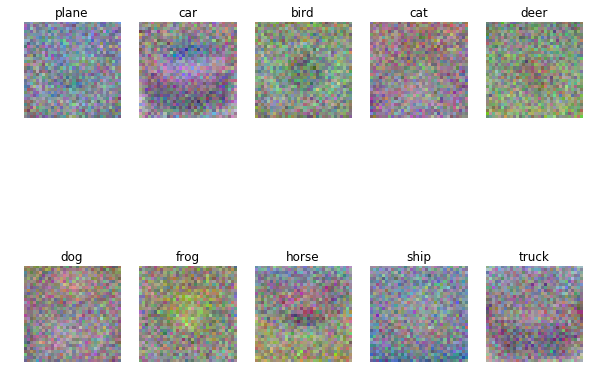

In [27]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])